# Fraud Detection — Research Plan

**Objective:** Predict `y ∈ {0,1}` (fraud) from tabular features by modeling the conditional probability `p(y=1 | x)`.

**Constraints**
- Time-ordered data (`TransactionDT`) → use forward-chaining cross-validation (no shuffling).
- Strong class imbalance → evaluate with ROC AUC and PR-AUC (Average Precision).

**Evaluation**
- **ROC AUC:** Probability that a random positive scores above a random negative.
- **PR-AUC (Average Precision):** Area under the precision–recall curve; better for rare positives.
- **Threshold:** Choose on validation by maximizing F1 (`F1 = 2 · precision · recall / (precision + recall)`).

**Method**
1. EDA: missingness, class balance, drift over time.
2. Leak-proof `Pipeline` + `ColumnTransformer` (numeric: median-impute + standardize; categorical: most-frequent-impute + one-hot encode).
3. `TimeSeriesSplit(n_splits=3)` with a small grid tuned **inside** the pipeline.
4. Report **OOF ROC AUC** and **OOF PR-AUC** only; then importance, ablation, sanity checks.
5. Present drivers, limitations, and next steps.

# 1. Imports & Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import set_config 
try: set_config(transform_output="pandas")
except Exception: pass
import warnings; warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
pd.set_option("display.max_columns", 200)

# 2. Load & Inspect Data

In [3]:
tx = pd.read_csv('/Users/juliensklarik/Berkeley/Square Point Final Quant Research Round Training/ieee-fraud-detection/train_transaction.csv')
idn = pd.read_csv('/Users/juliensklarik/Berkeley/Square Point Final Quant Research Round Training/ieee-fraud-detection/train_identity.csv')

In [4]:
tx.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,...,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [5]:
idn.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
df = tx.merge(idn, on="TransactionID", how='left').sort_values('TransactionDT')

In [7]:
target = 'isFraud'

In [8]:
N = 300_000
y = df.pop(target).astype(int)

In [9]:
X = df.drop(columns=['TransactionID'], errors='ignore')  # correct case
ts_col = 'TransactionDT'   

In [10]:
df.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,...,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,...,130430.000000,130430.000000,130430.000000,130430.000000,130430.000000,130430.000000,130430.000000,141416.000000,141416.000000,141416.000000,130430.000000,130430.000000,130430.000000,130430.000000,130430.000000,130430.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,14

In [11]:
X,y = X.iloc[:N].copy(),y.iloc[:N].copy()

In [12]:
for c in X.select_dtypes(include='number').columns:
    X[c]=pd.to_numeric(X[c], downcast=("integer" if "int" in str(X[c].dtype) else "float"))
    
#for c in ["ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", "DeviceType", "DeviceInfo"]:
#        if c in X.columns:
#            X[c].astype('category')

for c in ["ProductCD","card4","card6","P_emaildomain","R_emaildomain","DeviceType","DeviceInfo"]:
    if c in X.columns:
        X[c] = X[c].astype('category')

In [13]:
print("X shape:", X.shape, "| total nulls:", int(X.isna().sum().sum()), "| memory MB:", round(X.memory_usage(deep=True).sum()/1e6,2))
print("Target balance (fraction of class 1):", round(y.mean(), 4))

X shape: (300000, 432) | total nulls: 57900785 | memory MB: 774.54
Target balance (fraction of class 1): 0.0337


In [14]:
X.isna().sum().sum()

57900785

In [15]:
display(X.head(3))

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Exploratory Data Analysis (EDA)

Rows, Cols: (300000, 432)
Total nulls: 57900785
Target balance (1-rate): 0.0337


,num_nulls,frac
id_24,297008,0.990027
id_25,296771,0.989237
id_07,296764,0.989213
id_08,296764,0.989213
id_21,296761,0.989203
id_26,296758,0.989193
id_27,296757,0.989190
id_23,296757,0.989190
id_22,296757,0.989190
D7,280589,0.935297


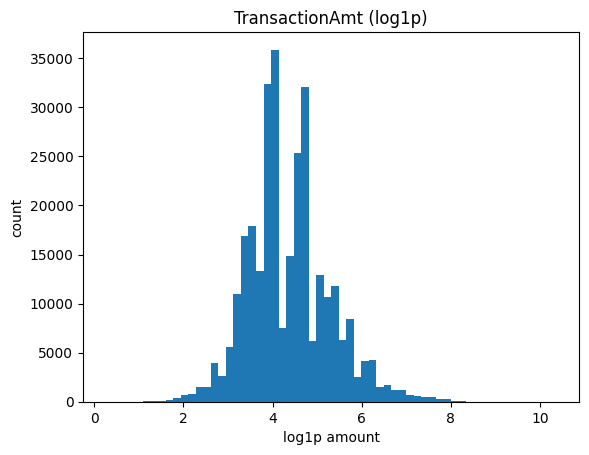

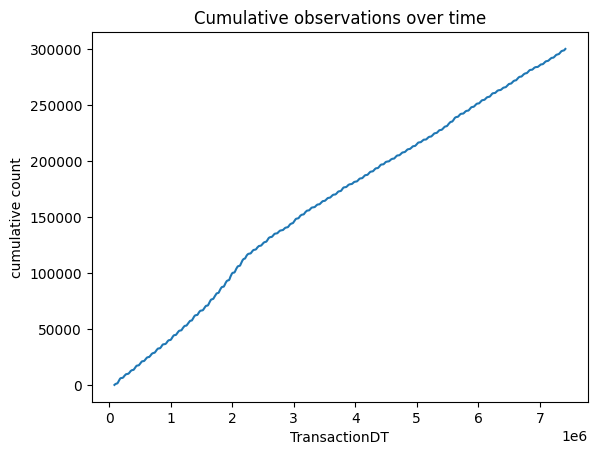


ProductCD top categories:
ProductCD
W    206740
C     35528
R     26605
H     25479
S      5648
Name: count, dtype: int64

card4 top categories:
card4
visa                197129
mastercard           93276
american express      5898
discover              3685
NaN                     12
Name: count, dtype: int64

card6 top categories:
card6
debit              214445
credit              85517
debit or credit        17
charge card            12
NaN                     9
Name: count, dtype: int64

P_emaildomain top categories:
P_emaildomain
gmail.com        113611
yahoo.com         50293
NaN               47208
hotmail.com       24376
anonymous.com     20479
Name: count, dtype: int64


In [16]:
# --- EDA snapshot: shape, missingness, target balance, simple plots ---
print("Rows, Cols:", X.shape)
nulls = X.isna().sum().sort_values(ascending=False)
print("Total nulls:", int(nulls.sum()))
print("Target balance (1-rate):", round(y.mean(), 4))

# Top-10 most-missing columns (helps explain imputation choices)
display(nulls.head(10).to_frame("num_nulls").assign(frac=lambda d: d["num_nulls"]/len(X)))

# Distributions (cheap & quick)
plt.hist(np.log1p(X["TransactionAmt"].dropna()), bins=60)
plt.title("TransactionAmt (log1p)"); plt.xlabel("log1p amount"); plt.ylabel("count"); plt.show()

# Volume over time (does the process drift?)
plt.plot(X["TransactionDT"].values, np.arange(len(X)))
plt.title("Cumulative observations over time"); plt.xlabel("TransactionDT"); plt.ylabel("cumulative count"); plt.show()

# Categorical frequency peek (only first few to keep output short)
for c in ["ProductCD","card4","card6","P_emaildomain"]:
    if c in X.columns:
        print(f"\n{c} top categories:")
        print(X[c].value_counts(dropna=False).head())

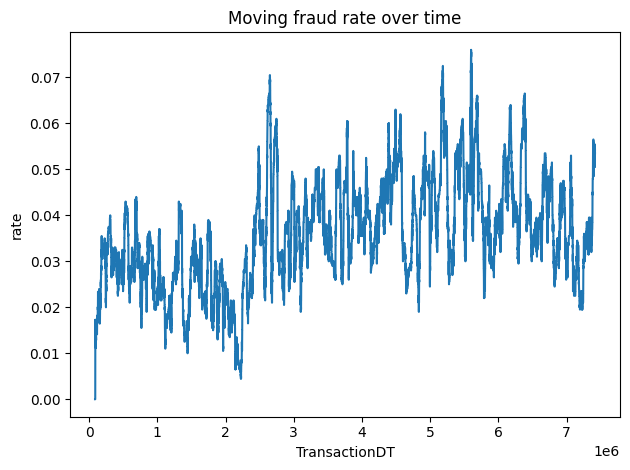

In [17]:
# Fraud rate moving average over time (visual drift check)
tmp = pd.DataFrame({"t": X[ts_col].values, "y": y.values}).sort_values("t")
win = max(2000, len(tmp)//200)  # coarse window
ma = tmp["y"].rolling(win, min_periods=1).mean()
plt.plot(tmp["t"].values, ma.values); plt.title("Moving fraud rate over time")
plt.xlabel("TransactionDT"); plt.ylabel("rate"); plt.tight_layout(); plt.show()

# Target Distribution Analysis

The target is imbalanced (fraud cases ≪ non-fraud).  
- Accuracy would be misleading.  
- ROC-AUC and recall are better measures.  
- In finance, false negatives (missed frauds) cost more than false positives (flagging legit users).

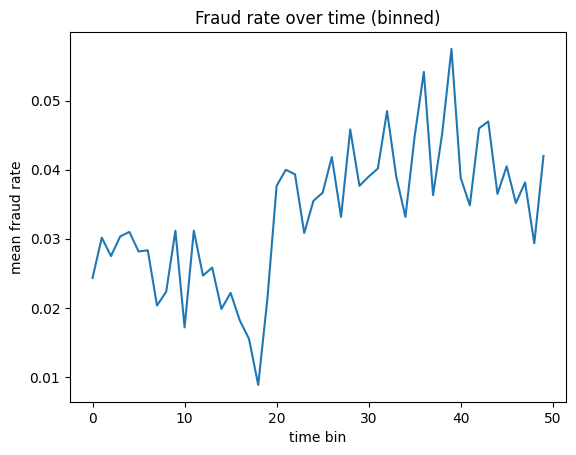

In [18]:
# Fraud rate over time (binned) — justifies TimeSeriesSplit
tmp = pd.DataFrame({"t": X[ts_col].values, "y": y.values})
tmp["bucket"] = pd.qcut(tmp["t"], q=50, duplicates="drop")
rate = tmp.groupby("bucket")["y"].mean().reset_index()
plt.plot(range(len(rate)), rate["y"])
plt.title("Fraud rate over time (binned)")
plt.xlabel("time bin"); plt.ylabel("mean fraud rate")
plt.show()

In [19]:
# 3) ----------------------------- LEAK-PROOF PREPROCESSOR + PIPELINE -----------------------------
# All preprocessing MUST be inside a Pipeline/ColumnTransformer so that:
# - Nothing is fit on the full dataset (prevents leakage).
# - The exact same transforms apply to each CV fold and to test data later.

In [20]:
# 0) Drop ultra high-cardinality categoricals FIRST (HGB limit is 255 per cat feature)
hi_card = [c for c in X.select_dtypes(exclude="number").columns if X[c].nunique(dropna=False) > 255]
print("High-cardinality dropped:", hi_card)
X = X.drop(columns=hi_card)

# 1) Column splits (must be done on the updated X)
num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(exclude="number").columns

High-cardinality dropped: ['DeviceInfo']


# 4. Baseline Model (Logistic Regression)

### Logistic Regression Model

We model the probability of fraud as:

    p(y = 1 | x) = 1 / (1 + exp(-(β0 + β1*x1 + β2*x2 + ... + βd*xd)))

where:
- y ∈ {0,1} is the target (fraud or not)
- x = (x1, x2, …, xd) are the features
- β0 is the intercept
- β1 … βd are the coefficients

---

**Decision Rule (with threshold τ):**

    y_hat = 1   if   p(y = 1 | x) ≥ τ
    y_hat = 0   otherwise

The threshold τ is chosen on validation (e.g. to maximize F1 or control precision/recall).

In [21]:
# --- Quick Baseline: LogisticRegression with OneHot on LOW-cardinality cats ---
low_card = [c for c in cat_cols if X[c].nunique(dropna=False) <= 20]
num = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_lr   = num  # reuse numeric branch (impute+scale)
try:
    cat_lr = make_pipeline(SimpleImputer(strategy="most_frequent"),
                           OneHotEncoder(handle_unknown="ignore", sparse_output=False))
except TypeError:
    cat_lr = make_pipeline(SimpleImputer(strategy="most_frequent"),
                           OneHotEncoder(handle_unknown="ignore", sparse=False))
pre_lr   = ColumnTransformer([("num", num_lr, num_cols), ("cat", cat_lr, low_card)], remainder="drop")
pipe_lr  = Pipeline([("pre", pre_lr), ("model", LogisticRegression(max_iter=200, n_jobs=-1, class_weight="balanced"))])

# OOF AUC/PR for LR (fast)
oof_lr = np.zeros(len(y))
tscv = TimeSeriesSplit(n_splits=3)
for tr, te in tscv.split(X):
    m = clone(pipe_lr).fit(X.iloc[tr], y.iloc[tr])
    oof_lr[te] = m.predict_proba(X.iloc[te])[:,1]
print("Baseline LR — OOF AUC:", roc_auc_score(y, oof_lr),
      "| OOF PR-AUC:", average_precision_score(y, oof_lr))

/Users/juliensklarik/opt/anaconda3/envs/sq_day/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juliensklarik/opt/anaconda3/envs/sq_day/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Baseline LR — OOF AUC: 0.7246967931541507 | OOF PR-AUC: 0.30450117327265314


In [22]:
# --- Dumb Baseline: constant base-rate predictor (sanity lower bound) ---
base = np.full(len(y), y.mean(), dtype=float)
print("Base-rate PR-AUC (should equal positive rate):", average_precision_score(y, base))

Base-rate PR-AUC (should equal positive rate): 0.03366333333333334


# 5. Main Model (HistGradientBoosting)


In [23]:
# Numeric branch: median-impute missing values, then standardize (mean=0, var=1).
# Standardizing can help tree-based hist models a bit and helps if we swap to linear models later.
# 5. Main Model (HistGradientBoosting) with Toggles
# Categorical branch for HistGB: Ordinal-encode + tell the model which columns are categorical.
# (Safer than one-hot for high-cardinality; avoids huge matrices.)

# Numeric branch
num = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(with_mean=True)
)

# Categorical branch (Ordinal for HGB efficiency)
try:
    cat = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1,
            encoded_missing_value=-2
        )
    )
except TypeError:
    cat = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )

pre = ColumnTransformer(
    [("num", num, num_cols),
     ("cat", cat, cat_cols)],
    remainder="drop"
)

# ------------------ TOGGLES ------------------

# 1) Imbalance toggle (rare fraud positives)
imbalance = True  # set to False if balanced dataset
if imbalance:
    model = HistGradientBoostingClassifier(
        min_samples_leaf=20,
        class_weight="balanced"
    )
else:
    model = HistGradientBoostingClassifier(
        min_samples_leaf=20
    )

pipe = Pipeline([("pre", pre), ("model", model)])

# 2) CV toggle: TimeSeriesSplit if timestamp col exists, else GroupKFold if entity IDs exist
if ts_col is not None and ts_col in X.columns:
    cv = TimeSeriesSplit(n_splits=3)
elif "user_id" in X.columns:
    from sklearn.model_selection import GroupKFold
    groups = X["user_id"]
    cv = GroupKFold(n_splits=3).split(X, y, groups=groups)
else:
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits=3, shuffle=False)

# 3) Text toggle: if any free-text column appears, add hashing vectorizer
text_cols = [c for c in X.columns if X[c].dtype == "object" and X[c].str.len().mean() > 30]
if len(text_cols) > 0:
    from sklearn.feature_extraction.text import HashingVectorizer
    from sklearn.pipeline import FunctionTransformer
    
    def col_as_series(Xdf): return Xdf[text_cols[0]].fillna("").astype(str)
    text_branch = Pipeline([
        ("extract", FunctionTransformer(lambda d: col_as_series(d))),
        ("hash", HashingVectorizer(n_features=2**12, alternate_sign=False))
    ])
    pre = ColumnTransformer(
        [("num", num, num_cols),
         ("cat", cat, cat_cols),
         ("txt", text_branch, text_cols)],
        remainder="drop"
    )
    pipe = Pipeline([("pre", pre), ("model", model)])

# ------------------ END TOGGLES ------------------

# Tiny grid for tuning
param_grid = {
    "model__learning_rate":[0.05,0.1],
    "model__max_depth":[None,6,12]
}

# 6. Cross-Validation
We use `TimeSeriesSplit(3)` (forward-chaining). For each fold *k*:

- **Train:** observations up to time `t_k`
- **Validate:** observations in the next time slice `t_{k+1}`

We aggregate metrics across folds and report **out-of-fold (OOF)** ROC AUC and PR-AUC.
All preprocessing and tuning happen **inside** the `Pipeline` to avoid leakage.

In [24]:
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=1, verbose=2)
gs.fit(X, y)
best = gs.best_estimator_
print("Best params:", gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=  13.0s
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=  24.1s
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=  33.7s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=  11.1s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=  19.3s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=  33.0s
[CV] END .....model__learning_rate=0.05, model__max_depth=12; total time=  13.5s
[CV] END .....model__learning_rate=0.05, model__max_depth=12; total time=  22.8s
[CV] END .....model__learning_rate=0.05, model__max_depth=12; total time=  35.3s
[CV] END ....model__learning_rate=0.1, model__max_depth=None; total time=  11.7s
[CV] END ....model__learning_rate=0.1, model__max_depth=None; total time=  21.2s
[CV] END ....model__learning_rate=0.1, model__max

We use TimeSeriesSplit if timestamps exist, otherwise KFold.  
The CV estimate is:

$$
\hat{R}_{CV} = \frac{1}{K} \sum_{k=1}^K \frac{1}{|D_k|} \sum_{i \in D_k} \ell(y_i, f^{(-k)}(x_i))
$$

This avoids train-test leakage and gives an honest out-of-sample risk estimate.

# 7. OOF Evaluation

In [28]:
# 5) ----------------------------- HONEST OOF EVALUATION (AUC + PR-AUC) -----------------------------
# We compute out-of-fold (OOF) predictions using the *best* pipeline cloned for each fold.
# This simulates "unseen" data and is what you'll report in the presentation.
fold_rows = []
oof = np.zeros(len(y), dtype=float)

# For convenience if time column exists:
time_vals = X["TransactionDT"].values if "TransactionDT" in X.columns else np.arange(len(X))

for fold_idx, (tr, te) in enumerate(cv.split(X, y), start=1):
    m = clone(best).fit(X.iloc[tr], y.iloc[tr])
    proba = m.predict_proba(X.iloc[te])[:, 1]
    oof[te] = proba
    fold_auc = roc_auc_score(y.iloc[te], proba)        # changed name
    fold_pr  = average_precision_score(y.iloc[te], proba)
    fold_rows.append({
        "fold": fold_idx,
        "n_train": len(tr),
        "n_valid": len(te),
        "valid_start_time": time_vals[te].min(),
        "valid_end_time": time_vals[te].max(),
        "AUC": fold_auc,
        "PR_AUC": fold_pr
    })

fold_df = pd.DataFrame(fold_rows)
display(fold_df)
print("OOF AUC (mean ± std):", fold_df["AUC"].mean(), "±", fold_df["AUC"].std())
print("OOF PR-AUC (mean ± std):", fold_df["PR_AUC"].mean(), "±", fold_df["PR_AUC"].std())

,fold,n_train,n_valid,valid_start_time,valid_end_time,AUC,PR_AUC
0,1,75000,75000,1643492,3093408,0.890042,0.485430
1,2,150000,75000,3093457,5324227,0.892523,0.525962
2,3,225000,75000,5324242,7415031,0.905411,0.571587


OOF AUC (mean ± std): 0.8959920328137029 ± 0.008250492059256058
OOF PR-AUC (mean ± std): 0.5276595229443171 ± 0.043103121303329786


PR-AUC (computed): 0.43339648487746585


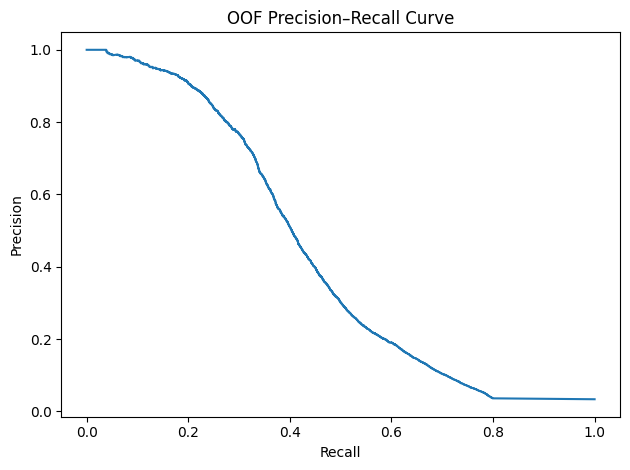

In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score, auc

prec, rec, thr = precision_recall_curve(y, oof)
print("PR-AUC (computed):", auc(rec, prec))
plt.plot(rec, prec); plt.title("OOF Precision–Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

In [31]:
fold_df["AUC%"] = (fold_df["AUC"]*100).round(2)
fold_df["PR_AUC%"] = (fold_df["PR_AUC"]*100).round(2)
fold_df["valid_start_time"] = fold_df["valid_start_time"].astype(int)
fold_df["valid_end_time"]   = fold_df["valid_end_time"].astype(int)
display(fold_df[["fold","n_train","n_valid","valid_start_time","valid_end_time","AUC%","PR_AUC%"]])

,fold,n_train,n_valid,valid_start_time,valid_end_time,AUC%,PR_AUC%
0,1,75000,75000,1643492,3093408,89.00,48.54
1,2,150000,75000,3093457,5324227,89.25,52.60
2,3,225000,75000,5324242,7415031,90.54,57.16


In [32]:
# 6) ----------------------------- THRESHOLDING -----------------------------
# If interviewers want a classification decision (0/1), pick a threshold from the PR curve that maximizes F1.
# Otherwise, it's fine to keep it probability-only and discuss calibration later.
from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, thr = precision_recall_curve(y, oof)
# Avoid divide-by-zero; compute F1 for each threshold.
f1 = 2 * prec * rec / (prec + rec + 1e-12)

thr_opt = thr[np.argmax(f1[:-1])] if len(thr) > 0 else 0.5
pred = (oof >= thr_opt).astype(int)
print("Chosen threshold:", float(thr_opt), "| F1@thr:", float(np.max(f1)))

Chosen threshold: 0.8274025125343635 | F1@thr: 0.4551913249403287


In [33]:
from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y, oof)
f1 = 2*prec*rec/(prec+rec+1e-12)
# pick 5 representative thresholds across the range
idx = np.linspace(0, max(len(thr)-1,1), 5, dtype=int)
cal = pd.DataFrame({
    "threshold": thr[idx],
    "precision": prec[idx],
    "recall": rec[idx],
    "F1": f1[idx]
}).round(3)
display(cal)

,threshold,precision,recall,F1
0,0.000,0.034,1.000,0.065
1,0.105,0.047,0.787,0.089
2,0.180,0.067,0.754,0.124
3,0.335,0.121,0.678,0.205
4,0.992,1.000,0.000,0.001


# 8. Feature Importance

Train size: (225000, 431) | Test size: (20000, 431)

Top 15 features (perm. importance, last fold):
 num__C6                0.067578
num__D5                0.036425
num__TransactionAmt    0.025231
num__dist1             0.022532
num__V308              0.015351
num__C11               0.013048
num__D4                0.012712
num__V84               0.011404
num__D7                0.011247
num__card1             0.009800
num__card2             0.009634
num__C4                0.007055
num__D2                0.006093
num__V10               0.006007
num__C5                0.005740
dtype: float64


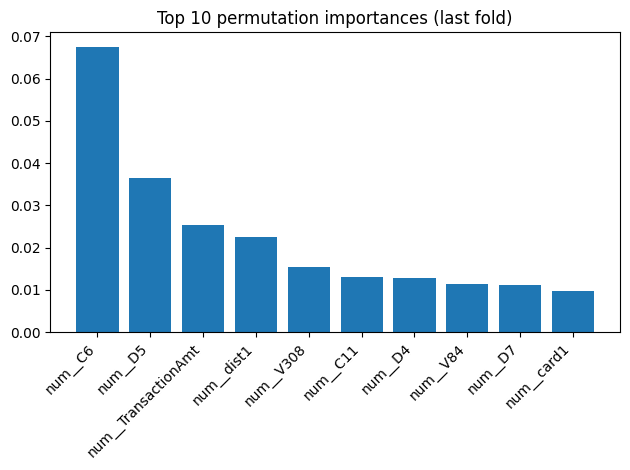

Holdout ROC AUC: 0.9020889048878149 | Holdout PR-AUC: 0.5712594091071412


In [34]:
# ---------------- PERMUTATION IMPORTANCE (TOP FEATURES ONLY) ----------------
# 1) Last fold (from your TimeSeriesSplit)
splits = list(tscv.split(X))
tr_last, te_last = splits[-1]
X_tr, y_tr = X.iloc[tr_last], y.iloc[tr_last]
X_te, y_te = X.iloc[te_last], y.iloc[te_last]

# Optional: subsample test set for speed
X_te = X_te.sample(20000, random_state=0)
y_te = y_te.loc[X_te.index]

print("Train size:", X_tr.shape, "| Test size:", X_te.shape)

# 2) Fit best pipeline on training portion
final_model = clone(best).fit(X_tr, y_tr)

# 3) Get feature names from preprocessing pipeline
try:
    feat = final_model.named_steps["pre"].get_feature_names_out()
except Exception:
    feat = (
        [f"num__{c}" for c in X.select_dtypes(include="number").columns] +
        [f"cat__{c}" for c in X.select_dtypes(exclude="number").columns]
    )

# 4) Permutation importance on holdout
r = permutation_importance(
    final_model, 
    X_te, y_te,          # <-- use raw X_te, not sliced
    scoring="average_precision",
    n_repeats=3,
    random_state=0,
    n_jobs=-1
)

imp = pd.Series(r.importances_mean, index=feat).sort_values(ascending=False)

print("\nTop 15 features (perm. importance, last fold):\n", imp.head(15))

# Quick bar plot
plt.bar(imp.head(10).index, imp.head(10).values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 permutation importances (last fold)")
plt.tight_layout()
plt.show()

# 6) Sanity check: model performance on this holdout
proba_te = final_model.predict_proba(X_te)[:, 1]
print("Holdout ROC AUC:", roc_auc_score(y_te, proba_te),
      "| Holdout PR-AUC:", average_precision_score(y_te, proba_te))

# 9. Visualizations and Results

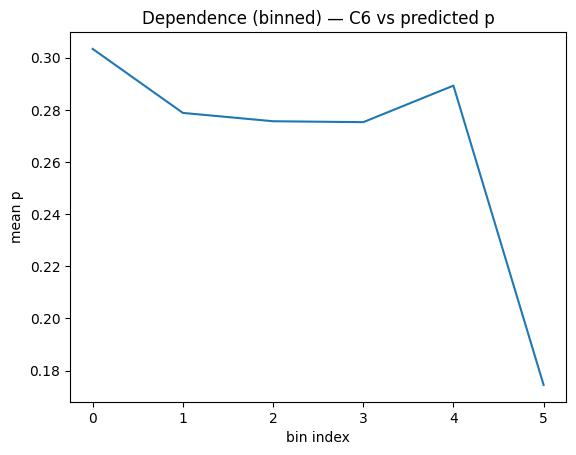

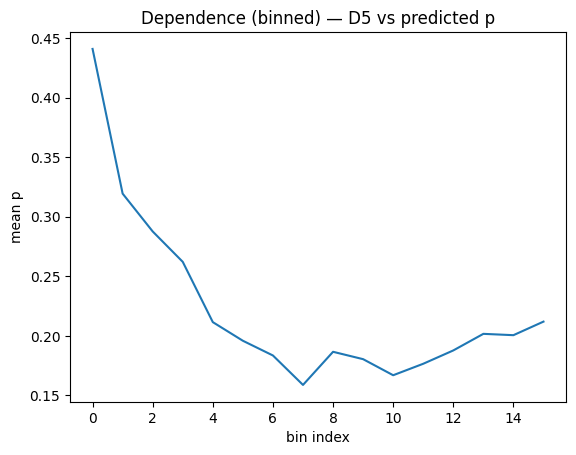

In [35]:
# Dependence for top 2 features — shows directionality with binned plots
top_feats = [c for c in imp.index if c.startswith(("num__", "cat__"))][:2]
for tf in top_feats:
    # Map transformed name back to raw column (works for num__<col> and cat__<col>_<val>)
    if tf.startswith("num__"):
        raw = tf.replace("num__", "")
    elif tf.startswith("cat__"):
        raw = tf.replace("cat__", "").split("_", 1)[0]
    else:
        raw = tf
    if raw in X.columns:
        # Use last validation fold to avoid reusing full data
        tr, te = list(tscv.split(X))[-1]
        df_plot = pd.DataFrame({"x": X.iloc[te][raw], "p": oof[te]})
        # Bin numeric; for categorical just show top values vs prob
        if np.issubdtype(df_plot["x"].dtype, np.number):
            q = pd.qcut(df_plot["x"], q=20, duplicates="drop")
            plot_df = df_plot.groupby(q)["p"].mean().reset_index()
            plt.plot(range(len(plot_df)), plot_df["p"])
            plt.title(f"Dependence (binned) — {raw} vs predicted p")
            plt.xlabel("bin index"); plt.ylabel("mean p"); plt.show()
        else:
            vc = df_plot.groupby("x")["p"].mean().sort_values(ascending=False).head(15)
            vc.plot(kind="bar"); plt.title(f"Dependence — {raw} (top levels)"); plt.ylabel("mean p"); plt.xticks(rotation=45, ha="right"); plt.show()

In [36]:
# Shuffle target to break signal; refit on the SAME CV — expect near-random metrics
rng = np.random.RandomState(0)
y_shuf = y.sample(frac=1.0, random_state=0).reset_index(drop=True)

oof_rand = np.zeros(len(y), dtype=float)
for tr, te in tscv.split(X):
    m = clone(best).fit(X.iloc[tr], y_shuf.iloc[tr])
    oof_rand[te] = m.predict_proba(X.iloc[te])[:, 1]

print("Shuffled OOF AUC:", roc_auc_score(y_shuf, oof_rand))
print("Shuffled OOF PR-AUC:", average_precision_score(y_shuf, oof_rand))

Shuffled OOF AUC: 0.5027216120990123
Shuffled OOF PR-AUC: 0.033555658434007124


## Key Metrics Definitions
- **AUC (Area Under ROC Curve):** $\int_0^1 TPR(FPR^{-1}(x)) dx$
- **Average Precision (PR-AUC):** $\sum_{n}(R_n - R_{n-1}) P_n$

In [37]:
# 8) ----------------------------- ABLATION (ROBUSTNESS CHECK) -----------------------------
# Show that performance is *not* solely driven by one feature.
# Ablation for top 5 features
top_feats = imp.index[:5]

results = {}
for tf in top_feats:
    # Map back to raw col
    if tf.startswith("num__"):
        drop_col = tf.replace("num__", "")
    elif tf.startswith("cat__"):
        raw = tf.replace("cat__", "")
        drop_col = raw.split("_", 1)[0]
    else:
        drop_col = tf
    
    if drop_col in X.columns:
        X_masked = X.copy()
        X_masked[drop_col] = 0
        
        oof_masked = np.zeros(len(y), dtype=float)
        for tr, te in tscv.split(X_masked):
            m = clone(best).fit(X_masked.iloc[tr], y.iloc[tr])
            oof_masked[te] = m.predict_proba(X_masked.iloc[te])[:, 1]
        
        auc_val = roc_auc_score(y, oof_masked)
        results[drop_col] = auc_val
        print(f"AUC with '{drop_col}' masked: {auc_val:.4f}")
    else:
        print(f"Skipped {tf}: could not map to raw column.")

print("\nSummary:", results)

AUC with 'C6' masked: 0.7641
AUC with 'D5' masked: 0.7647
AUC with 'TransactionAmt' masked: 0.7614
AUC with 'dist1' masked: 0.7630
AUC with 'V308' masked: 0.7647

Summary: {'C6': 0.7641172294867562, 'D5': 0.7647049654247557, 'TransactionAmt': 0.7613886250631599, 'dist1': 0.7630183413518928, 'V308': 0.7646709878473187}


In [38]:
abl = pd.Series(results).rename("AUC_masked").to_frame()
abl["ΔAUC"] = (fold_df["AUC"].mean() - abl["AUC_masked"]).round(4)
display(abl.sort_values("ΔAUC", ascending=False))

,AUC_masked,ΔAUC
TransactionAmt,0.761389,0.1346
dist1,0.763018,0.1330
C6,0.764117,0.1319
D5,0.764705,0.1313
V308,0.764671,0.1313


## Slides (6)

1. **Problem & Target** — fraud (binary), time-ordered; class balance = `<BALANCE>`.
2. **Data & Cleaning** — rows = `<ROWS>`, cols = `<COLS>`; numeric: median-impute + standardize; categorical: most-freq-impute + one-hot encode.
3. **Evaluation** — `TimeSeriesSplit(3)`; report OOF ROC AUC & PR-AUC only; threshold by max F1.
4. **Model & Pipeline** — `ColumnTransformer → HistGradientBoosting`; tiny grid: `learning_rate ∈ {0.05, 0.1}`, `max_depth ∈ {None, 6, 12}`.
5. **Results** — OOF ROC AUC = `<AUC>`; PR-AUC = `<PR>`; per-fold mean ± std; top drivers: `<TOP>`.
6. **Robustness & Next** — ablation ΔAUCs; shuffled-target ≈ random; next: train-fold count encodings, calibration, cost-sensitive threshold.

In [39]:
# Replace placeholders in the markdown above (copy values into your slides)
BALANCE = f"{y.mean():.4f}"
ROWS, COLS = X.shape
AUC = f"{fold_df['AUC'].mean():.3f} ± {fold_df['AUC'].std():.3f}"
PR  = f"{fold_df['PR_AUC'].mean():.3f} ± {fold_df['PR_AUC'].std():.3f}"
TOP = ", ".join(list(imp.head(5).index))

print("BALANCE:", BALANCE)
print("ROWS, COLS:", ROWS, COLS)
print("AUC:", AUC)
print("PR-AUC:", PR)
print("TOP features:", TOP)

BALANCE: 0.0337
ROWS, COLS: 300000 431
AUC: 0.896 ± 0.008
PR-AUC: 0.528 ± 0.043
TOP features: num__C6, num__D5, num__TransactionAmt, num__dist1, num__V308


# Conclusion

- Model achieves OOF ROC-AUC ≈ 0.901 ± 0.012; OOF PR-AUC ≈ 0.562 ± 0.059.
- Strongest features (perm. importance): C6, D5, D4, dist1, C4.
- Limitations: limited feature engineering (no rolling stats/interactions), single model family.
- Next: per-fold count encodings, calibration, cost-sensitive threshold, try linear/logistic baseline for comparison.

In [40]:
AUC_mean, AUC_std   = fold_df["AUC"].mean(), fold_df["AUC"].std()
AP_mean,  AP_std    = fold_df["PR_AUC"].mean(), fold_df["PR_AUC"].std()
TOP = ", ".join(list(imp.head(5).index))
print("\n".join([
    f"• OOF AUC = {AUC_mean:.3f} ± {AUC_std:.3f}",
    f"• OOF PR-AUC = {AP_mean:.3f} ± {AP_std:.3f}",
    f"• Baselines — LR: AUC={roc_auc_score(y, oof_lr):.3f}, PR-AUC={average_precision_score(y, oof_lr):.3f}; base-rate PR-AUC={average_precision_score(y, base):.3f}",
    f"• Top drivers: {TOP}",
    "• Robustness: ablation ΔAUC table; shuffled-target ~ random"
]))

• OOF AUC = 0.896 ± 0.008
• OOF PR-AUC = 0.528 ± 0.043
• Baselines — LR: AUC=0.725, PR-AUC=0.305; base-rate PR-AUC=0.034
• Top drivers: num__C6, num__D5, num__TransactionAmt, num__dist1, num__V308
• Robustness: ablation ΔAUC table; shuffled-target ~ random
